URL DEL DATASET: [EDA cardiovascular data](https://www.kaggle.com/sulianova/eda-cardiovascular-data)

# Importamos librerías necesarias


In [188]:
import os
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  
from scipy.stats.stats import pearsonr
from statsmodels.formula.api import ols
import math
from google.colab import drive

# Preparamos nuestro dataset

In [189]:
drive.mount('mydrive')

Drive already mounted at mydrive; to attempt to forcibly remount, call drive.mount("mydrive", force_remount=True).


In [190]:
dataset = pd.read_csv ("/content/mydrive/MyDrive/EDEM/Data Project/cardio.csv", sep=",")

Antes de trabajar con el dataset comprobamos que no hay ningún valor que falte o sea null

In [191]:
dataset.isnull().values.any()

False

In [192]:
#Guardo las variables que voy a utilizar
age = dataset.age  #Este edad está en días
dataset['years_old'] = (dataset['age'] / 365).round().astype('int') #Creo la variable 'years_old', la cual es 'age' pero dividida entre 365 para tener la edad en años
sistolica = dataset.ap_hi
diastolica = dataset.ap_lo
colesterol = dataset.cholesterol
fumador = dataset.smoke
bebedor = dataset.alco
activo = dataset.active

Para las variables nominales, aclarar lo siguiente:
En 'gender': el valor 1 es mujeres y el valor 2 es hombres
En 'cholesterol': el valor 1 es saludable, 2 es riesgo y 3 es no saludable
En 'active': el valor 0 es no actividad física y el 1 es que si lo hay
En 'cardio': el valor 0 es no problemas cardíacos y el 1 es que si los hay

De modo lo creamos las variables_cat para que quede clarificado

In [193]:
dataset.loc[(dataset['gender']==1),"gender_cat"]= "Female"
dataset.loc[(dataset['gender']==2),"gender_cat"]= "Male"
dataset.loc[(dataset['cholesterol']==1),"chol_cat"]= "Saludable"
dataset.loc[(dataset['cholesterol']==2),"chol_cat"]= "Elevado"
dataset.loc[(dataset['cholesterol']==3),"chol_cat"]= "No saludable"
dataset.loc[(dataset['smoke']==0),"smoke_cat"]= "No fumador"
dataset.loc[(dataset['smoke']==1),"smoke_cat"]= "Fumador"
dataset.loc[(dataset['alco']==0),"alco_cat"]= "No bebe"
dataset.loc[(dataset['alco']==1),"alco_cat"]= "Bebe"
dataset.loc[(dataset['active']==0),"active_cat"]= "No hace ejercicio"
dataset.loc[(dataset['active']==1),"active_cat"]= "Hace ejercicio"
dataset.loc[(dataset['cardio']==0),"cardio_cat"]= "Sin reporte cardiovascular"
dataset.loc[(dataset['cardio']==1),"cardio_cat"]= "Con reporte cardiovascular"

Mostramos los cambios y eliminamos las columnas que no vamos a trabajar para una visión más clara

In [194]:
dataset.drop(['id','height', 'weight','gluc','ap_hi','ap_lo'], axis=1)

,age,gender,cholesterol,smoke,alco,active,cardio,years_old,gender_cat,chol_cat,smoke_cat,alco_cat,active_cat,cardio_cat
0,18393,2,1,0,0,1,0,50,Male,Saludable,No fumador,No bebe,Hace ejercicio,Sin reporte cardiovascular
1,20228,1,3,0,0,1,1,55,Female,No saludable,No fumador,No bebe,Hace ejercicio,Con reporte cardiovascular
2,18857,1,3,0,0,0,1,52,Female,No saludable,No fumador,No bebe,No hace ejercicio,Con reporte cardiovascular
3,17623,2,1,0,0,1,1,48,Male,Saludable,No fumador,No bebe,Hace ejercicio,Con reporte cardiovascular
4,17474,1,1,0,0,0,0,48,Female,Saludable,No fumador,No bebe,No hace ejercicio,Sin reporte cardiovascular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,1,1,0,1,0,53,Male,Saludable,Fumador,No bebe,Hace ejercicio,Sin reporte cardiovascular
69996,22601,1,2,0,0,1,1,62,Female,Elevado,No fumador,No bebe,Hace ejercicio,Con reporte cardiovascular
69997,19066,2,3,0,1,0,1,52,Male,No saludable,No fumador,Bebe,No hace ejercicio,Con reporte cardiovascular
69998,22431,1,1,0,0,0,1,61,Female,Saludable,No fumador,No bebe,No hace ejercicio,Con reporte cardiovascular


# Trabajamos nuestra variable predicha, la edad

In [195]:
years_old = dataset['years_old'].describe()
years_old

count    70000.000000
mean        53.338686
std          6.765294
min         30.000000
25%         48.000000
50%         54.000000
75%         58.000000
max         65.000000
Name: years_old, dtype: float64

In [196]:
n = years_old[0]
m_years_old = years_old[1]
sd_years_old = years_old[2]

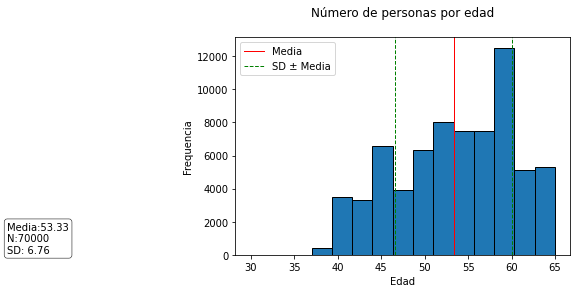

In [197]:
edad = dataset['years_old']
plt.hist(edad, bins=15, edgecolor='black')
plt.xlabel('Edad')
plt.xticks(np.arange(30, 70, step= 5))
plt.ylabel('Frequencia')
props = dict(boxstyle= 'round', facecolor='white', lw=0.5)
plt.text(2,100,'Media:53.33''\n''N:70000' '\n' 'SD: 6.76', bbox=props)
plt.title('Número de personas por edad''\n')
plt.axvline(53.33, linewidth=1, linestyle='solid', color = 'red')
plt.axvline(46.57, linewidth=1, linestyle= 'dashed', color= 'green')
plt.axvline(60.10, linewidth=1, linestyle= 'dashed', color= 'green')
plt.legend(labels=['Media', 'SD ± Media'])
plt.show()

# Trabajamos nuestras variables predictoras

# Colesterol
1: normal, saludable

2: ligeramente por encima de lo normal, situación de posible riesgo

3: muy por encima de lo normal, no saludable


In [198]:
col_table = dataset.groupby(['cholesterol']).size()
print(col_table)
n=col_table.sum()
col_table2 = (col_table/n)*100
print(col_table2)
n=col_table.sum()

cholesterol
1    52385
2     9549
3     8066
dtype: int64
cholesterol
1    74.835714
2    13.641429
3    11.522857
dtype: float64


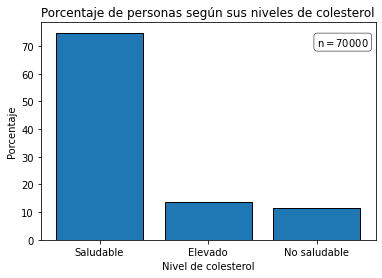

In [199]:
bar_list = ['Saludable', 'Elevado','No saludable']
plt.bar(bar_list, col_table2, edgecolor='black')
plt.title("Porcentaje de personas según sus niveles de colesterol")
plt.ylabel('Porcentaje')
plt.xlabel('Nivel de colesterol')
props = dict(boxstyle='round', facecolor='white',lw=0.5)
textstr = '$\mathrm{n}=%.0f$'%(n)
plt.text (2,70, textstr , bbox=props)
plt.show()

In [200]:
dataset.groupby('chol_cat').years_old.mean()

chol_cat
Elevado         53.712326
No saludable    56.200471
Saludable       52.829932
Name: years_old, dtype: float64

In [201]:
#Descriptive comparison
dataset.groupby('chol_cat').years_old.mean()
#Statistical comparison
col_sana=dataset.loc[dataset.chol_cat=='Saludable', "years_old"]
col_riesgo=dataset.loc[dataset.chol_cat=='Elevado', "years_old"]
col_no_sana=dataset.loc[dataset.chol_cat=='No saludable', "years_old"]

stats.f_oneway(col_sana, col_riesgo, col_no_sana)

F_onewayResult(statistic=907.2369830978461, pvalue=0.0)

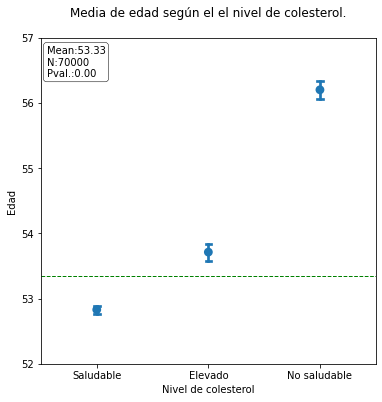

In [202]:
plt.figure(figsize=(6,6))
ax = sns.pointplot(x="chol_cat", y="years_old", data=dataset,capsize=0.05, ci=95, join=0, order=['Saludable', 'Elevado', 'No saludable'])
ax.set_ylabel('Edad')
plt.yticks(np.arange(52, 58, step=1))
plt.axhline(y=dataset['years_old'].mean(),linewidth=1,linestyle= 'dashed',color="green")
props = dict(boxstyle='round', facecolor='white', lw=0.5)
plt.text(-0.45,56.4,'Mean:53.33''\n''N:70000''\n' 'Pval.:0.00', bbox=props)
plt.xlabel('Nivel de colesterol')
plt.title('Media de edad según el el nivel de colesterol.''\n')
plt.show()

Como el p valor es menor de 0.05, rechazamos la hipótesis nula.

La edad afecta significativamente a una persona en base a su situación con el colesterol.

# Activo y no activo

In [203]:
acti_table = dataset.groupby(['active']).size()
print(acti_table)
n=acti_table.sum()
acti_table2 = (acti_table/n)*100
print(acti_table2)
n=acti_table.sum()

active
0    13739
1    56261
dtype: int64
active
0    19.627143
1    80.372857
dtype: float64


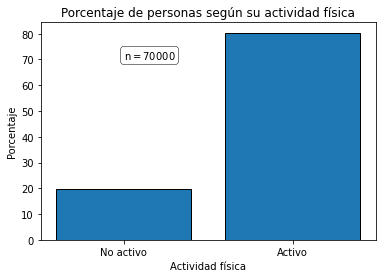

In [204]:
bar_list = ['No activo', 'Activo']
plt.bar(bar_list, acti_table2, edgecolor='black')
plt.title("Porcentaje de personas según su actividad física")
plt.ylabel('Porcentaje')
plt.xlabel('Actividad física')
props = dict(boxstyle='round', facecolor='white',lw=0.5)
textstr = '$\mathrm{n}=%.0f$'%(n)
plt.text (0,70, textstr , bbox=props)
plt.show()

In [205]:
#Descriptive comparison
dataset.groupby('active').years_old.mean()

active
0    53.473106
1    53.305860
Name: years_old, dtype: float64

In [206]:
#Statistical comparison
no_activos=dataset.loc[dataset.active_cat=='Hace ejercicio', "years_old"]
activos=dataset.loc[dataset.active_cat=='No hace ejercicio', "years_old"]

res = stats.f_oneway(no_activos, activos)
print(res)

F_onewayResult(statistic=6.748948182092627, pvalue=0.009382260765441006)


Como el p valor es menor de 0.05, rechazamos la hipótesis nula.

La edad afecta significativamente a una persona en base a su situación de actividad física.

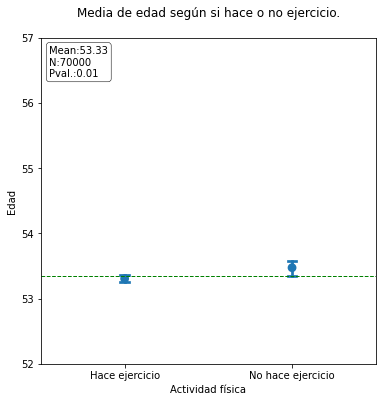

In [207]:
plt.figure(figsize=(6,6))
ax = sns.pointplot(x="active_cat", y="years_old", data=dataset,capsize=0.05, ci=95, join=0, order=['Hace ejercicio', 'No hace ejercicio'])
ax.set_ylabel('Edad')
plt.yticks(np.arange(52, 58, step=1))
plt.axhline(y=dataset['years_old'].mean(),linewidth=1,linestyle= 'dashed',color="green")
props = dict(boxstyle='round', facecolor='white', lw=0.5)
plt.text(-0.45,56.4,'Mean:53.33''\n''N:70000''\n' 'Pval.:0.01', bbox=props)
plt.xlabel('Actividad física')
plt.title('Media de edad según si hace o no ejercicio.''\n')
plt.show()

# Problemas cardíacos

In [208]:
card_table = dataset.groupby(['cardio_cat']).size()
print(card_table)
n=card_table.sum()
card_table2 = (card_table/n)*100
print(card_table2)
n=card_table.sum()
pd.crosstab(dataset['cardio_cat'],dataset['gender_cat'],normalize=True)

cardio_cat
Con reporte cardiovascular    34979
Sin reporte cardiovascular    35021
dtype: int64
cardio_cat
Con reporte cardiovascular    49.97
Sin reporte cardiovascular    50.03
dtype: float64


gender_cat,Female,Male
cardio_cat,,
Con reporte cardiovascular,0.323086,0.176614
Sin reporte cardiovascular,0.327343,0.172957


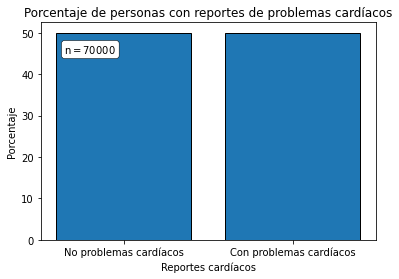

In [209]:
bar_list = ['No problemas cardíacos', 'Con problemas cardíacos']
plt.bar(bar_list, card_table2, edgecolor='black')
plt.title("Porcentaje de personas con reportes de problemas cardíacos")
plt.ylabel('Porcentaje')
plt.xlabel('Reportes cardíacos')
props = dict(boxstyle='round', facecolor='white',lw=0.5)
textstr = '$\mathrm{n}=%.0f$'%(n)
plt.text (-0.35,45, textstr , bbox=props)
plt.show()

In [210]:
#Descriptive comparison
dataset.groupby('cardio_cat').years_old.mean()

cardio_cat
Con reporte cardiovascular    54.948083
Sin reporte cardiovascular    51.731218
Name: years_old, dtype: float64

In [211]:
#Statistical comparison
no_cardio=dataset.loc[dataset.cardio_cat=='Sin reporte cardiovascular', "years_old"]
cardio=dataset.loc[dataset.cardio_cat=='Con reporte cardiovascular', "years_old"]

res = stats.f_oneway(no_cardio, cardio)
print(res)

F_onewayResult(statistic=4193.661785519235, pvalue=0.0)


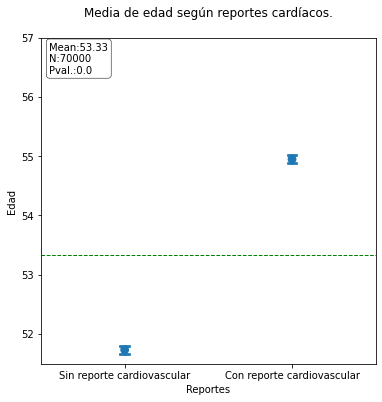

In [212]:
plt.figure(figsize=(6,6))
ax = sns.pointplot(x="cardio_cat", y="years_old", data=dataset,capsize=0.05, ci=95, join=0, order=['Sin reporte cardiovascular', 'Con reporte cardiovascular'])
ax.set_ylabel('Edad')
plt.yticks(np.arange(52, 58, step=1))
plt.axhline(y=dataset['years_old'].mean(),linewidth=1,linestyle= 'dashed',color="green")
props = dict(boxstyle='round', facecolor='white', lw=0.5)
plt.text(-0.45,56.4,'Mean:53.33''\n''N:70000''\n' 'Pval.:0.0', bbox=props)
plt.xlabel('Reportes')
plt.title('Media de edad según reportes cardíacos.''\n')
plt.show()

# Ahora dejamos de tomar como predicha la edad para comparar por sexo
Lo analizamos para poder justificar que las mujeres pagan menos por un seguro de vida

1.   ¿Quién consume más alcohol?
2.   ¿Quién fuma más?



Primero veamos como efectivamente las mujeres tienen más esperanza de vida:

[Esperanza de vida general y por sexo en España](https://datosmacro.expansion.com/demografia/esperanza-vida/espana)

En el enlace mencionado observamos como la esperanza de vida en España es de 82,33 años(2020).

Para hombres es de 79,59 y en mujeres es de 85,06 años.

# Consumo del alcohol, ¿quien bebe más?

Empecemos por observar cuantos beben:



alco_cat
Bebe        5.377143
No bebe    94.622857
dtype: float64


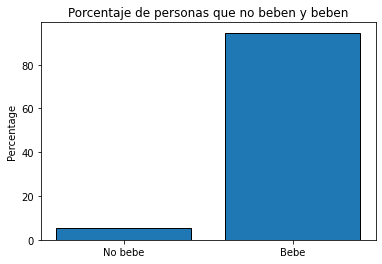

In [213]:
alco_table = dataset.groupby(['alco_cat']).size()
n=alco_table.sum()
alco_table2 = (alco_table/n)*100
print(alco_table2)
bar_list = ['No bebe', 'Bebe']
plt.bar(bar_list, alco_table2,edgecolor='black')
plt.ylabel('Percentage')
plt.title('Porcentaje de personas que no beben y beben')
plt.show()

gender_cat
Female    65.042857
Male      34.957143
dtype: float64


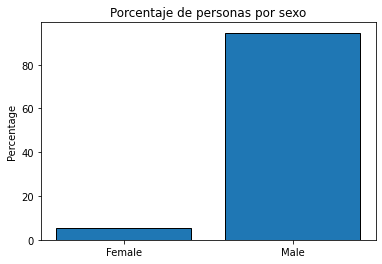

In [214]:
gender_table = dataset.groupby(['gender_cat']).size()
n=gender_table.sum()
gender_table2 = (gender_table/n)*100
print(gender_table2)
bar_list = ['Female', 'Male']
plt.bar(bar_list, alco_table2,edgecolor='black')
plt.ylabel('Percentage')
plt.title('Porcentaje de personas por sexo')
plt.show()

gender_cat  Female  Male   All
alco_cat                      
Bebe           2.5  10.6   5.4
No bebe       97.5  89.4  94.6


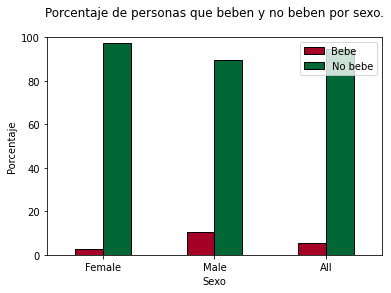

<Figure size 432x288 with 0 Axes>

In [215]:
#Crostabulation
pd.crosstab(dataset.alco_cat, dataset.gender_cat, margins=True) #1º la VD target, 2º La predicción
pd.crosstab(dataset.alco_cat, dataset.gender_cat,normalize='columns', margins=True)*100 #Para que nos de en porcentajes
my_ct = pd.crosstab(dataset.alco_cat, dataset.gender_cat,normalize='columns', margins=True)*100
my_ct=round(my_ct,1)
print(my_ct)
stats.chi2_contingency(ct)
#Ploting the cross tabulation
my_ct2=my_ct.transpose() #Primero hay que treansponer la tabla para poder representarla graficamente
my_ct2.plot(kind="bar", edgecolor = "black", colormap='RdYlGn')
props = dict(boxstyle='round', facecolor='white', lw=0.5)
plt.xlabel('Sexo')
plt.title('Porcentaje de personas que beben y no beben por sexo.''\n')
plt.ylabel('Porcentaje')
plt.legend(['Bebe','No bebe'])
plt.ylim(0,100)
plt.xticks(rotation='horizontal')
plt.show()
plt.savefig('Gender_Alcohol.svg')

# Consumo del alcohol, ¿quien fuma más?

Empecemos por observar cuantos fuman:

smoke_cat
Fumador        8.812857
No fumador    91.187143
dtype: float64


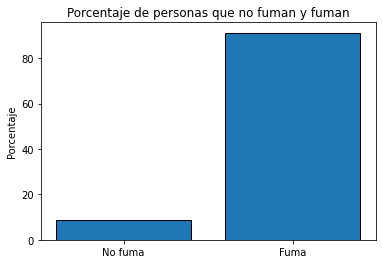

In [216]:
smoke_table = dataset.groupby(['smoke_cat']).size()
n=smoke_table.sum()
smoke_table2 = (smoke_table/n)*100
print(smoke_table2)
bar_list = ['No fuma','Fuma']
plt.bar(bar_list, smoke_table2,edgecolor='black')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de personas que no fuman y fuman')
plt.show()

gender_cat  Female  Male   All
smoke_cat                     
Fumador        1.8  21.9   8.8
No fumador    98.2  78.1  91.2


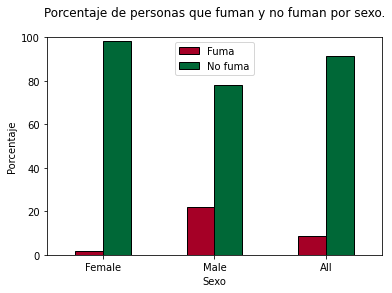

<Figure size 432x288 with 0 Axes>

In [217]:
#Crostabulation
pd.crosstab(dataset.smoke_cat, dataset.gender_cat, margins=True) #1º la VD target, 2º La predicción
pd.crosstab(dataset.smoke_cat, dataset.gender_cat,normalize='columns', margins=True)*100 #Para que nos de en porcentajes
my_ct = pd.crosstab(dataset.smoke_cat, dataset.gender_cat,normalize='columns', margins=True)*100
my_ct=round(my_ct,1)
print(my_ct)
stats.chi2_contingency(ct)
#Ploting the cross tabulation
my_ct2=my_ct.transpose() #Primero hay que treansponer la tabla para poder representarla graficamente
my_ct2.plot(kind="bar", edgecolor = "black", colormap='RdYlGn')
props = dict(boxstyle='round', facecolor='white', lw=0.5)
plt.xlabel('Sexo')
plt.title('Porcentaje de personas que fuman y no fuman por sexo.''\n')
plt.ylabel('Porcentaje')
plt.legend(['Fuma','No fuma'])
plt.ylim(0,100)
plt.xticks(rotation='horizontal')
plt.show()
plt.savefig('Gender_Alcohol.svg')